# Import Packages

In [54]:
import json, re, collections, itertools, gensim, spacy, logging, warnings, statistics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from tqdm import tqdm_notebook as tqdm
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
import gensim.corpora as corpora
from wordcloud import WordCloud
import matplotlib.colors as mcolors
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from textblob import TextBlob
import pyLDAvis.gensim
from scipy import stats
plt.style.use('seaborn-pastel')
sns.color_palette('pastel')

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

# Import Data

In [3]:
in_paths = '../microbiome_pat'
### Conditional allows flexiblity in length of `in_paths` which allows ad-hoc merging of patent files
if len(in_paths) == 1:
    with open(f'{in_paths}.json', 'r') as f:
        patent_data = json.load(f)
elif len(in_paths) > 1:
    patent_data = {}
    for in_path in in_paths:
        with open(f'{in_path}.json', 'r') as f:
            tmp_data = json.load(f)
            print(f'{len(tmp_data.keys())} patents loaded from {in_path}')
        patent_data.update(tmp_data)

patent_ids = [i for i in list(patent_data.keys())]
### JSON keys are an ID formed with `search_term`_`result_number`
terms = [i.split('_')[0] for i in patent_ids]

print(f'\nTerms found in the {len(patent_ids)} loaded patents include: {set(terms)}\n')
for term in set(terms):
    term_ids = [i.split('_')[1] for i in patent_ids if i.split('_')[0] == term]
    print(f'Minimum {term} patent result number : {min(term_ids)}\nMaximum {term} patent result number : {max(term_ids)}')

### Document number is a unique number assigned by the USPTO so it can be used 
### to deduplicate between files generated with different search queries
unique_patent_data = {v['document_number'].replace(',', '') : dict(search_id=k, **v) for (k,v) in patent_data.items()}

print(f'\nWithin the {len(patent_ids)} patents, there were {len(unique_patent_data.keys())} unique patents.')

Terms found in the 3083 loaded patents include: {'probiotic', 'microbiome'}

Minimum probiotic patent result number : 000001
Maximum probiotic patent result number : 002000
Minimum microbiome patent result number : 000001
Maximum microbiome patent result number : 001084

Within the 3083 patents, there were 2624 unique patents.


# Why uBiome?

I noticed while skimming the microbiome data I had already pulled, that uBiome was one of the most frequent patent applicants out of the first ~3500 patents I pulled. As it was a company I'd heard of, I figured I'd take a look at what they're patenting.

Using uBiome's [wikipedia page](https://en.wikipedia.org/wiki/UBiome) (as their official website is no longer functional), you can learn about their product. It sounds like after purchasing, one would receive a kit which would be used to collect a microbiome sample from one of several body sites. This sample would be submitted to uBiome who would use PCR to amplify 16S rRNA which allowed them to identify bacteria at a [genus](https://en.wikipedia.org/wiki/Genus) level. Customers also submitted a survey about specific conditions related to the body site sampled. 

uBiome would use this data and their algorithms to compare customers to their database of microbiomes and associated conditions from partners and other customers. Using this data, uBiome could ideally recommend changes to customer's microbiomes which would help them move toward "healthier" microbiome and away from the microbiome associated with their conditions. 

Unfortunately, [they will not get the chance to try this.](https://www.forbes.com/sites/alexknapp/2019/10/02/health-testing-startup-ubiome-files-for-chapter-7-with-plans-to-shut-down/#39eb97984b4a). 

Anywho, this information will help us get an idea of what to expect from their patents. 

In [4]:
ubiome_patents = {k:v for (k,v) in unique_patent_data.items() if v['applicant'] == 'uBiome, Inc.'}
ubiome_patents_numbers = [i['document_number'] for (k, i) in ubiome_patents.items()]

# Analysis

## Patent Number Data

We'll start by looking at the distribution of the USPTO's assigned patent numbers. This are assigned incrementally across all patents, so this number essentially serves as a proxy for time normalized for the rate in which patents are filed. 

### Patent Number Statistics

In [55]:
patent_numbers = [int(i['document_number'].replace(',', '')) for i in ubiome_patents.values()]
patent_numbers = [i for i in patent_numbers if i > 2]
patent_numbers_stdev = statistics.stdev(patent_numbers)
patent_numbers_mean = statistics.mean(patent_numbers)
patent_numbers_z = [(i-patent_numbers_mean) / patent_numbers_stdev for i in patent_numbers]
print(f'Minimum patent number : {min(patent_numbers)}\nMaximum patent number : {max(patent_numbers)}')
print(f'\nMinimum patent z-score : {min(patent_numbers_z)}\nMaximum patent z-score : {max(patent_numbers_z)}')
print(f'\nUnscaled summary : \n{stats.describe(patent_numbers)}')
print(f'\nScaled summary : \n{stats.describe(patent_numbers_z)}')

Minimum patent number : 9663831
Maximum patent number : 10415105

Minimum patent z-score : -3.358528469932686
Maximum patent z-score : 0.7850428023834255

Unscaled summary : 
DescribeResult(nobs=56, minmax=(9663831, 10415105), mean=10272768.30357143, variance=32873586747.41526, skewness=-2.447117074554927, kurtosis=4.757395084681475)

Scaled summary : 
DescribeResult(nobs=56, minmax=(-3.358528469932686, 0.7850428023834255), mean=-2.9500211797182733e-15, variance=0.9999999999999999, skewness=-2.4471170745549187, kurtosis=4.757395084681446)


### Patent Number Distribution

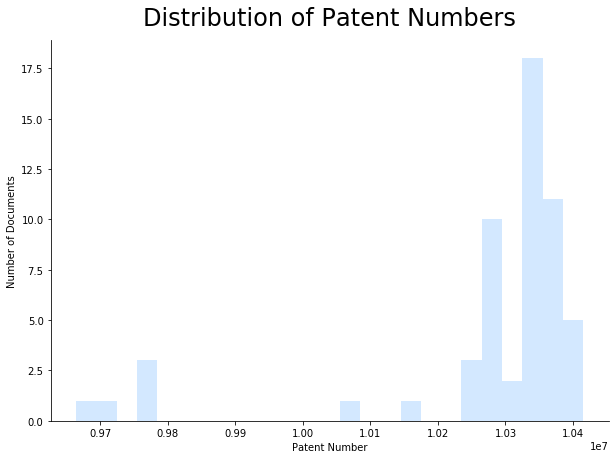

In [67]:
fig = plt.figure(figsize=(10,7), facecolor='white')
sns.distplot([i for i in patent_numbers], kde=False, bins=25)
plt.title('Distribution of Patent Numbers', fontsize=24, pad=15)
#plt.ylabel('Number of Documents')
#plt.ylabel('Number of Documents')
plt.gca().set(ylabel='Number of Documents', xlabel='Patent Number')
sns.despine()
plt.show()

## Publication Date Data

### Publication Date Lists

The dates are a bit messy so there's cleaning to do. 

In [69]:
pub_dates = [i['publication_date'] for i in ubiome_patents.values() if i['publication_date'] != '']
pub_dates = [i.replace('rch', 'Mar').replace('ary', 'Feb').replace('ust', 'Aug') for i in pub_dates]
pub_dates = [i.replace('ril', 'Apr').replace('une', 'Jun').replace('uly', 'Jul') for i in pub_dates]

pub_dates = [dt.datetime.strptime(i, '%b %d, %Y') for i in pub_dates]

Now I'll break up the publication dates by `year-quarter` and by `year`. I'll also count the top occuring `year-quarter`s and `years`. 

In [71]:
pub_quarters = [str(i.year) + '-' + f'{pd.Timestamp(i).quarter}' for i in pub_dates]
pub_quarter_count = dict(collections.Counter(pub_quarters))
n = 25
top_pubquarter_list = sorted(pub_quarter_count, key=pub_quarter_count.get, reverse=True)[:n]
top_pubquarter_count_list = [pub_quarter_count[i] for i in top_pubquarter_list]


pub_years = [str(i.year) for i in pub_dates]
pub_year_count = dict(collections.Counter(pub_years))
n = 25
top_pubyear_list = sorted(pub_year_count, key=pub_year_count.get, reverse=True)[:n]
top_pubyear_count_list = [pub_year_count[i] for i in top_pubyear_list]


all_pub_quarters_list = sorted(pub_quarter_count, reverse=False)
all_pubquarter_count_list = [pub_quarter_count[i] for i in all_pub_quarters_list]

### Publication Date Plots

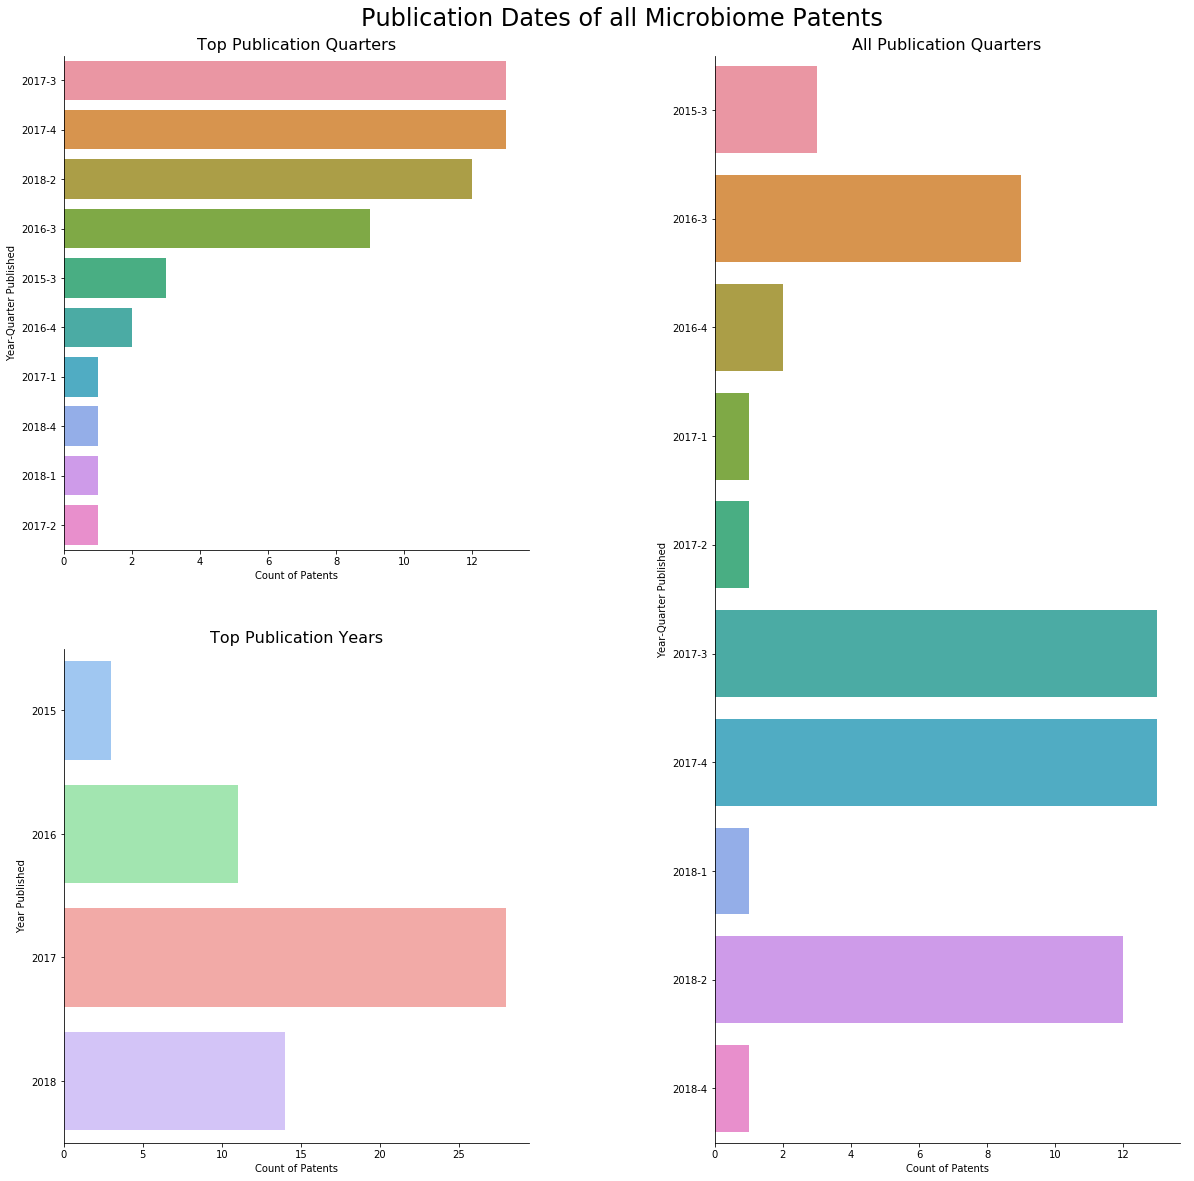

In [73]:
### White background
fig = plt.figure(figsize=(20,20), facecolor='white')
ax = fig.add_subplot(111, fc='white')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

### Set up a grid
grid = plt.GridSpec(2, 2, hspace=0.2, wspace=0.4)
plt.title('Publication Dates of all Microbiome Patents', pad=30, fontsize=24)
ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[1,0])
ax3 = fig.add_subplot(grid[:,1])
sns.despine()

sns.barplot(top_pubquarter_count_list, top_pubquarter_list, ax=ax1)
sns.barplot(top_pubyear_count_list, top_pubyear_list, ax=ax2, orient='horizontal')
sns.barplot(all_pubquarter_count_list, all_pub_quarters_list, ax=ax3, orient='horizontal')

ax1.set_title('Top Publication Quarters', fontsize=16)
ax2.set_title('Top Publication Years', fontsize=16)
ax3.set_title('All Publication Quarters', fontsize=16)

ax1.set_xlabel('Count of Patents')
ax2.set_xlabel('Count of Patents')
ax3.set_xlabel('Count of Patents')

ax1.set_ylabel('Year-Quarter Published')
ax2.set_ylabel('Year Published')
ax3.set_ylabel('Year-Quarter Published')

plt.show()

## Primary Examiner 
### Data

In [78]:
PEs = [i['primary_examiner'] for i in ubiome_patents.values()]
### Names are formatted LAST_NAME; FIRST_NAME so this list comp. rearranges that
PEs = [i.split('; ')[1] + ' ' + i.split('; ')[0] for i in PEs]
### Normalizing the J so PEs group properly
PEs = [i.replace('Dejong', 'DeJong') for i in PEs]
PEs_count = dict(collections.Counter(PEs))
n = 25
### Sort descending by PE count, get top `n` PEs
top_PE_list = sorted(PEs_count, key=PEs_count.get, reverse=True)[:n]
top_PEcount_list = [PEs_count[i] for i in top_PE_list]

### Plot

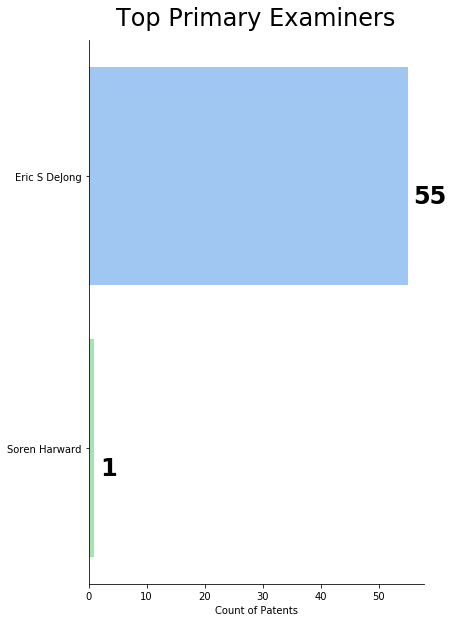

In [79]:
fig = plt.figure(figsize=(6,10), facecolor='white')
sns.barplot(top_PEcount_list, top_PE_list)
sns.despine()
plt.title('Top Primary Examiners', fontsize=24, pad=15)
plt.xlabel('Count of Patents')

for i, v in enumerate(top_PEcount_list):
    plt.gca().text(v+1, i+.1, str(v), fontweight='bold', fontsize=24)

plt.show()

Looks like [Eric S DeJong](https://www.patentbots.com/stats/examiner/1631-DEJONG-ERIC-S) examined a majority of uBiome's patents. Looks like Eric is [not an easy examiner](https://www.patentbots.com/stats/examiner/1631-DEJONG-ERIC-S)! 

## Inventors Data

Each patent comes with a list of inventors so I'll remove some junk from the text and then rearrange the names. 

In [117]:
inventors = [i['inventors'].replace('Inventors: ', '') for i in ubiome_patents.values()]
print(f'\n{inventors[0]}')

### This regex should remove the (City, STATE) from after each persons name
inventors = [re.sub(r'\(.{1,20}, .{1,2}\)', '', i) for i in inventors]
print(f'\n{inventors[0]}')

inventors = [[j.strip() for j in re.split(',', i)] for i in inventors]
inventors = [[j.split('; ')[1] + ' ' + j.split('; ')[0] for j in i] for i in inventors]

all_inventors = []
for inventor in inventors:
    all_inventors += inventor
    
print(f'\n{all_inventors[:5]}')


Apte; Zachary (San Francisco, CA), Richman; Jessica (San Francisco, CA), Almonacid; Daniel (San Francisco, CA)

Apte; Zachary , Richman; Jessica , Almonacid; Daniel 

['Zachary Apte', 'Jessica Richman', 'Daniel Almonacid', 'Zachary Apte', 'Daniel Almonacid']


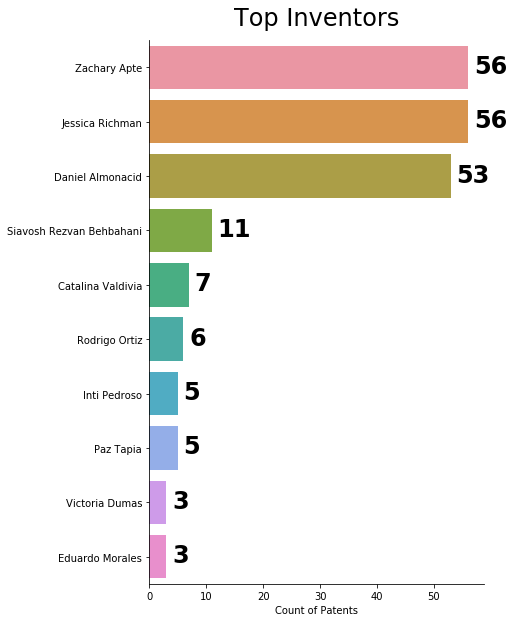

In [118]:
inventors_count = dict(collections.Counter(all_inventors))
n = 25
top_inventor_list = sorted(inventors_count, key=inventors_count.get, reverse=True)[:n]
top_inventorcount_list = [inventors_count[i] for i in top_inventor_list]

fig = plt.figure(figsize=(6,10), facecolor='white')
sns.barplot(top_inventorcount_list, top_inventor_list)
sns.despine()
plt.title('Top Inventors', fontsize=24, pad=15)
plt.xlabel('Count of Patents')

for i, v in enumerate(top_inventorcount_list):
    plt.gca().text(v+1, i+.1, str(v), fontweight='bold', fontsize=24)

plt.show()

No surprises here. Zachary Apte is the [co-founder and CTO of uBiome](https://www.crunchbase.com/person/zachary-apte) and Jessica Richman is the [CEO and other co-founder](https://www.crunchbase.com/person/jessica-richman). I don't want to link anything personal here but I'd highly recommend googling their names and reading a few articles. 

## Abstract Data

The next piece of data to analyze are the abstracts. First I'll clean up the text. 

In [119]:
abstracts = [i['abstract'].lower() for i in ubiome_patents.values()]
abstracts = [re.sub(r'[,;#()-:]|(\.)|(\.$)', '', i) for i in abstracts]
abstracts[:5]

['an embodiment of a method for diagnostic testing includes providing a sampling kit to a subject the sampling kit including a sample container for reception of a sample from a collection site of the subject receiving the sample from the subject generating a microbiome sequence dataset based upon sequencing nucleic acid content of a microorganism portion of the sample detecting a presence of a set of microbiome targets generating a diagnostic analysis based on the detected set of microbiome targets generating a therapy recommendation based on the set of microbiome targets and promoting the therapy recommendation in coordination with presenting information derived from the diagnostic analysis',
 'a method for at least one of characterizing diagnosing and treating a cutaneous condition in at least a subject the method comprising receiving an aggregate set of biological samples from a population of subjects generating at least one of a microbiome composition dataset and a microbiome funct

### N-Gram Lists

Now I'll convert each abstract into a list of n-grams. I'll do this for 1, 2, and 3-grams. I'll also build a corpus of words/phrases for each N-Gram. 

In [15]:
stop_words = set(stopwords.words('english')) 
fil_abstracts = []
ngrams_2 = []
ngrams_3 = []

corpus_1grams = []
corpus_2grams = []
corpus_3grams = []
st = PorterStemmer()
### Loop through abstracts and build 1-gram, 2-gram and 3-gram lists
for abstract in tqdm(abstracts, total=len(abstracts)):
    word_tokens = word_tokenize(abstract)
    ### Stem each word and remove stop words
    filtered_abstract = [st.stem(w) for w in word_tokens if not w in stop_words]
    
    ### Append each list of filtered words from each abstract to a `fil_abstracts` for later
    fil_abstracts.append(filtered_abstract)
    
    ### Create n-gram objects using TextBlob 
    ngram_2 = TextBlob(' '.join(filtered_abstract)).ngrams(2)
    ngram_3 = TextBlob(' '.join(filtered_abstract)).ngrams(3)
    ### Join each n-gram with an underscore then add them to the ngram corpuses
    ngrams_2.append(['_'.join(i) for i in ngram_2])
    ngrams_3.append(['_'.join(i) for i in ngram_3])
    
    ### Add the list of words to the 1-gram corpus list
    corpus_1grams += filtered_abstract
    corpus_2grams += ['_'.join(i) for i in ngram_2]
    corpus_3grams += ['_'.join(i) for i in ngram_3]

### Take the set of each corpus because we don't need repeats
corpus_1grams = list(set(corpus_1grams))
corpus_2grams = list(set(corpus_2grams))
corpus_3grams = list(set(corpus_3grams))

### N-Gram Frequencies

Now I'll build dictionaries which will count the number of times each n-gram appears and the number of documents it appears in. 

In [120]:
### Term Frequency across all abstracts
freq_dicts = {}
df_dicts = {}

for ngram, list_of_grams in [('1', fil_abstracts), ('2', ngrams_2), ('3', ngrams_3)]:
    freq_dict = {}
    ### Loop through each document's text
    for abstract_words in list_of_grams:
        for word in abstract_words:
            if word not in freq_dict.keys():
                freq_dict[word] = 1
            else:
                freq_dict[word] += 1
    freq_dicts[ngram] = freq_dict

    ### Document Frequency counting number of abstracts a word appears in
    df_dict = {}
    for abstract_words in list_of_grams:
        ### Loop through the unique words in the document
        for word in set(abstract_words):
            if word not in df_dict.keys():
                df_dict[word] = 1
            else:
                df_dict[word] += 1
    df_dicts[ngram] = df_dict
    
    

In [129]:
def n_gram_analysis(plot_title, freq_dicts = freq_dicts, df_dicts = df_dicts, 
                    list_of_ngrams = fil_abstracts, ngram = '1', 
                    num_static_grams = 25, num_dynam_grams = 10, 
                    pub_quarters = pub_quarters):
    if num_static_grams < num_dynam_grams:
        print('Lower the number of dynamic grams or increase static grams.')
        return None
    ### Build a list of the most frequent grams based on raw count and number of documents they appear in.
    ### Raw count
    top_gram_list = sorted(freq_dicts[ngram], key=freq_dicts[ngram].get, reverse=True)[:num_static_grams]
    top_gram_count_list = [freq_dicts[ngram][i] for i in top_gram_list]

    ### Number of Documents
    top_df_list = sorted(df_dicts[ngram], key=df_dicts[ngram].get, reverse=True)[:num_static_grams]
    top_df_count_list = [df_dicts[ngram][i] for i in top_df_list]
    
    
    ab_text_year_quarter = {}
    ab_count_year_quarter = {}
    ### Build a combined "mega-abstract" for each year_quarter
    ### Also count the number of abstracts added to each year quarter
    for abstract, year_quarter in zip(list_of_ngrams, pub_quarters):
        if year_quarter not in ab_text_year_quarter.keys():
            ab_text_year_quarter[year_quarter] = abstract
            ab_count_year_quarter[year_quarter] = 1
        else:
            ab_text_year_quarter[year_quarter] += abstract
            ab_count_year_quarter[year_quarter] += 1
    
    
    common_terms_by_time = {}
    ### For the `num_dynam_grams` that'll be tracked over time, for each one, check the number
    ### Of times the gram appears in each `year_quarter`'s combined abstract (AKA its mega_abstract)
    for common_term in top_gram_list[:num_dynam_grams]:
        word_count = 0
        common_terms_by_time[common_term] = {}
        for year_quarter in sorted(ab_text_year_quarter.keys()):
            for word in ab_text_year_quarter[year_quarter]:
                if common_term == word:
                    word_count += 1
                    continue
            common_terms_by_time[common_term][year_quarter] = word_count
    
    ### White background
    fig = plt.figure(figsize=(16,20), facecolor='white')
    ax = fig.add_subplot(111, fc='white')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    
    grid = plt.GridSpec(2, 2, hspace=0.2, wspace=0.5)
    plt.title(plot_title, pad=40, fontsize=24)
    ax1 = fig.add_subplot(grid[0,0])
    ax2 = fig.add_subplot(grid[0,1])
    ax3 = fig.add_subplot(grid[1,:])
    sns.despine()
    
    sns.barplot(top_gram_count_list, top_gram_list, ax=ax1)
    sns.barplot(top_df_count_list, top_df_list, ax=ax2, orient='horizontal')
    x_values = []
    labels = []
    ### Build lists of values for stacked plot
    for term, term_dict in common_terms_by_time.items():
        x_values.append(list(term_dict.values()))
        labels.append(term)
        y_values = common_terms_by_time[term].keys()

    ax3.stackplot(y_values, x_values, labels=labels)
    ax3.set_xticklabels(labels = list(term_dict.keys()), rotation=90)
    for index, label in enumerate(ax3.xaxis.get_ticklabels()):
        ### If the x ticklabel isn't divisible by 3, hide it.
        if index % 3 != 0:
            label.set_visible(False)
    ax1.set_title(f'Raw Count of Most Frequently Used {ngram}-Grams', fontsize=16)
    ax2.set_title(f'Number of Documents Using the Most Frequent {ngram}-Grams', fontsize=16)
    ax3.set_title(f'Popular {ngram}-Gram Frequencies Over Time', fontsize=16)
    ax3.legend(loc='upper left')
    ax1.set(xlabel=f'Raw Count of {ngram}-Gram')
    ax2.set(xlabel=f'Documents Containing {ngram}-Gram')
    ax3.set(xlabel='Year-Quarter', ylabel='Count of Grams')
    

    plt.show()

### N-Gram Plots

#### 1-Gram

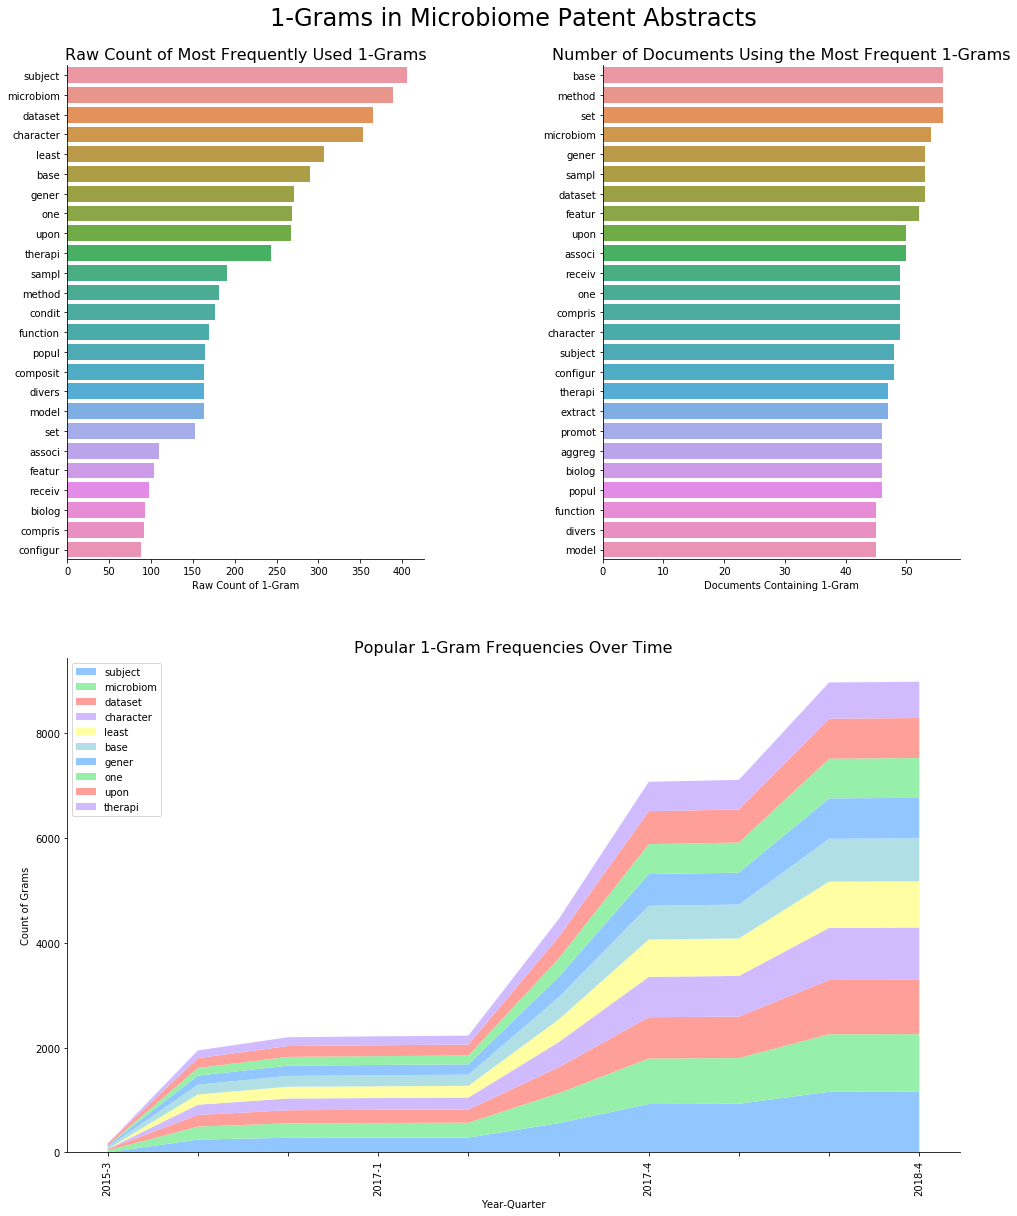

In [130]:
n_gram_analysis(ngram='1', list_of_ngrams = fil_abstracts, plot_title=f'1-Grams in Microbiome Patent Abstracts')

#### 2-Gram

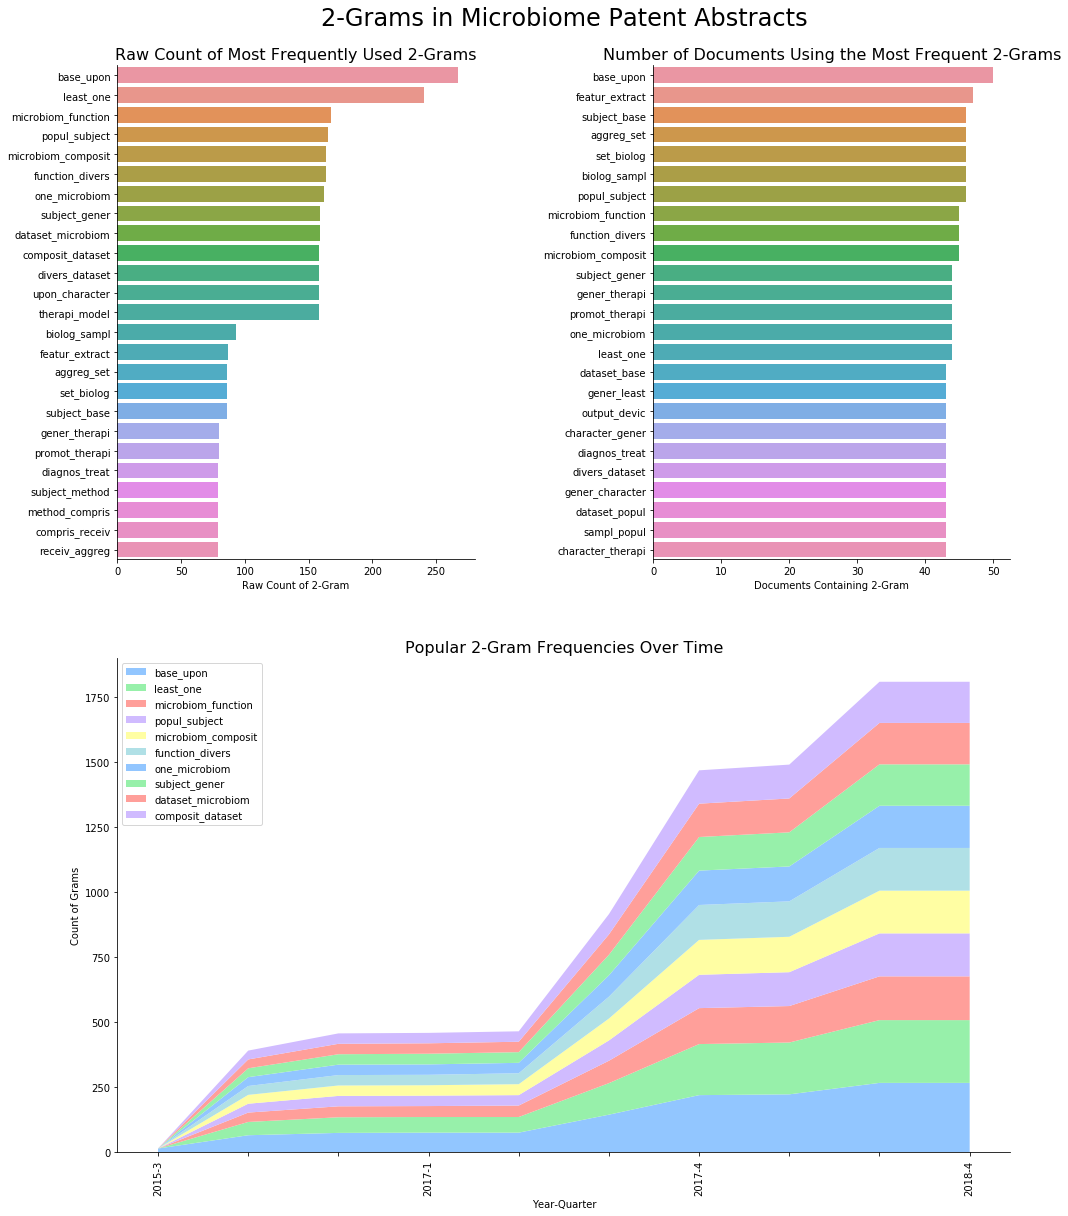

In [131]:
n_gram_analysis(ngram='2', list_of_ngrams = ngrams_2, plot_title=f'2-Grams in Microbiome Patent Abstracts')

#### 3-Gram

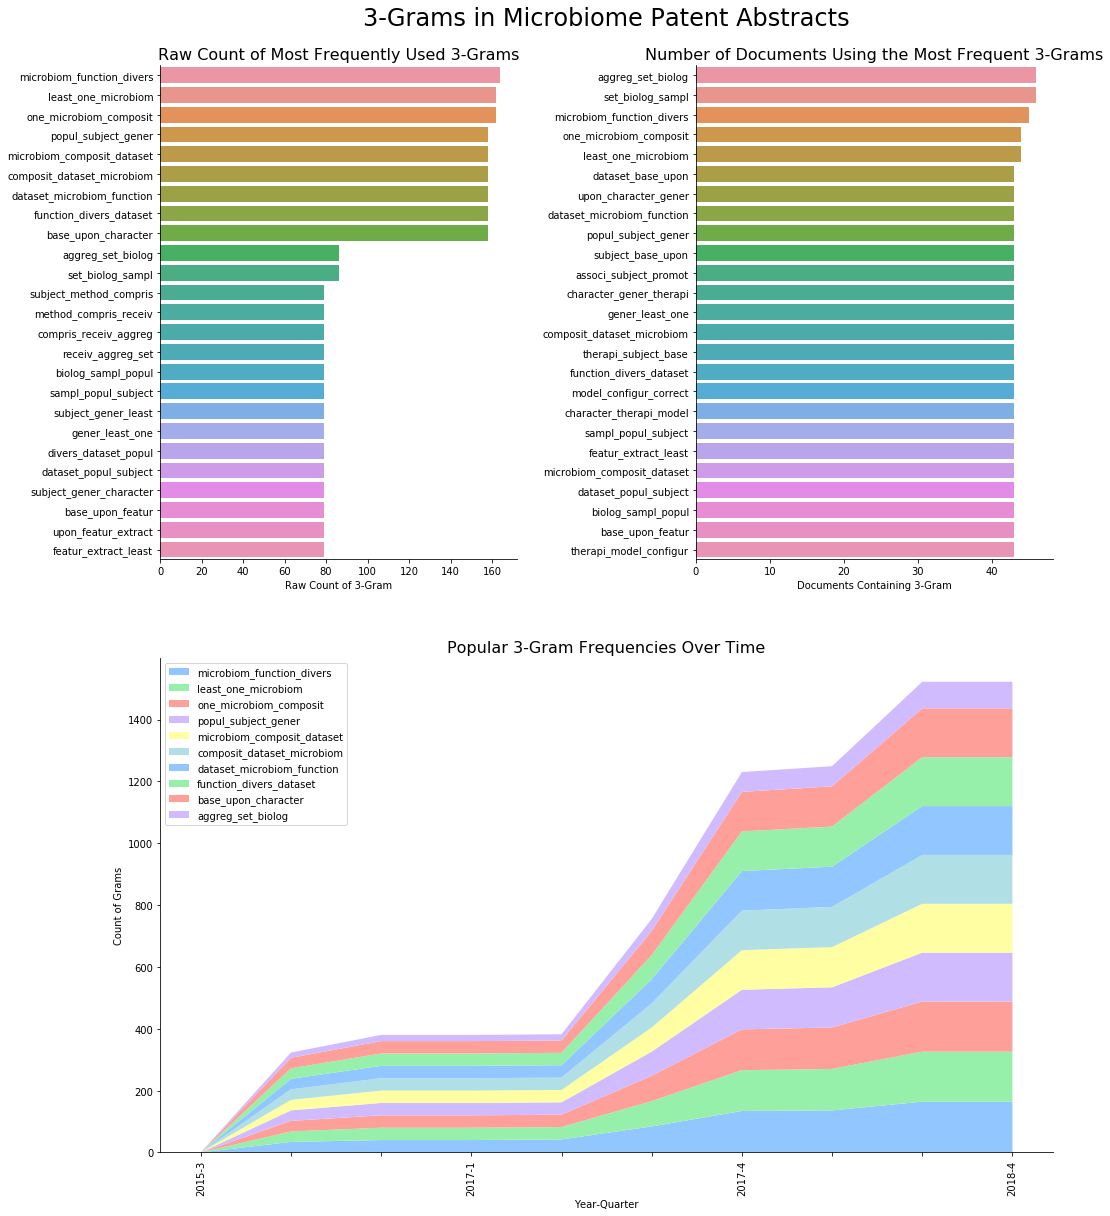

In [132]:
n_gram_analysis(ngram='3', list_of_ngrams = ngrams_3, plot_title=f'3-Grams in Microbiome Patent Abstracts')

### LDA Topic Model

The next step in further understanding of the abstracts is to map the topics. To do this, I'll use LDA topic modeling which is an unsupervised clustering technique which uses the frequencies of the words (or n-grams) in a document to add the document to a "topic". A document can be assigned to multiple topics and LDA will assign a value which represents the amount that topic contributed to a document. This can be understood as the model's confidence in that topic assignment. 

Some of the ideas for my LDA analyses came from this [MachineLearningPlus article](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/). I wasn't able to find a specific author but I'd still like to give them credit for the backbone of some of these analyses. 

In [21]:
lda_models = {}
number_topics = 4

for ngram, list_of_grams in tqdm([('1', fil_abstracts), ('2', ngrams_2), ('3', ngrams_3)], total=3):
    print(f'Creating {ngram}-Gram LDA Topic Model with {number_topics} Topics')
    
    count_vectorizer = CountVectorizer(stop_words='english')
    
    count_data = count_vectorizer.fit_transform([' '.join(i) for i in list_of_grams])

    lda = LDA(n_components=number_topics, n_jobs=-1)
    lda.fit(count_data)
    ### Create a dictionary of ID to word mappings
    id2word = corpora.Dictionary(list_of_grams)
    ### Build a document corpus using an ID-word mapping
    corpus = [id2word.doc2bow(text) for text in list_of_grams]
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=number_topics, 
                                               update_every=1,
                                               passes=10,
                                               alpha='symmetric',
                                               iterations=100,
                                               per_word_topics=True)

    for topic in lda_model.print_topics():
        print('\t', topic)
    lda_models[f'{ngram}_model'] = lda_model
    lda_models[f'{ngram}_corpus'] = corpus
    

Creating 1-Gram LDA Topic Model with 4 Topics
	 (0, '0.060*"subject" + 0.051*"microbiom" + 0.050*"character" + 0.048*"dataset" + 0.044*"least" + 0.038*"upon" + 0.037*"base" + 0.037*"therapi" + 0.037*"one" + 0.036*"gener"')
	 (1, '0.076*"sampl" + 0.043*"set" + 0.039*"sequenc" + 0.037*"microbiom" + 0.035*"microorgan" + 0.032*"individu" + 0.032*"base" + 0.027*"portion" + 0.023*"upon" + 0.023*"dataset"')
	 (2, '0.065*"subject" + 0.052*"microbiom" + 0.048*"least" + 0.048*"dataset" + 0.048*"character" + 0.046*"issu" + 0.046*"neurolog" + 0.046*"health" + 0.040*"gener" + 0.040*"therapi"')
	 (3, '0.066*"subject" + 0.058*"dataset" + 0.057*"character" + 0.057*"microbiom" + 0.052*"least" + 0.045*"one" + 0.041*"condit" + 0.041*"base" + 0.040*"gener" + 0.039*"therapi"')
Creating 2-Gram LDA Topic Model with 4 Topics
	 (0, '0.026*"base_upon" + 0.025*"microorgan_portion" + 0.018*"sampl_kit" + 0.017*"receiv_sampl" + 0.017*"microbiom_sequenc" + 0.017*"sampl_collect" + 0.017*"collect_site" + 0.017*"sampl_

While this print out may be informative (sort of), its tough to read. A word cloud would be much easier on the eyes.

In [133]:
def topic_word_cloud(num_topics, lda_model, ngram, max_words = 20, max_font_size = 300):
    
    cloud = WordCloud(stopwords=stop_words,background_color='white',max_words=max_words)
    
    topics = lda_model.show_topics(formatted=False)

    grid_rows = int(np.floor(num_topics / 2))

    ### Background of the plot
    fig = plt.figure(figsize=(15,10), facecolor='white')
    ax = fig.add_subplot(111, fc='white')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    grid = plt.GridSpec(grid_rows, 2, hspace=0.2, wspace=0.3)
    plt.title(f'{ngram}-Gram Cloud of Abstract Topics', pad=40, fontsize=24)
    for topic_number, (row_i, col_j) in enumerate(itertools.product(range(0, grid_rows), range(0, 2))):
        ### Somtimes, this loop will overshoot so break when it does.
        if topic_number >= num_topics:
            break
        ax = fig.add_subplot(grid[row_i, col_j])
        topic_words = dict(topics[topic_number][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(topic_number), fontdict=dict(size=16, fontweight='bold'), pad=20)
        plt.gca().axis('off')

    sns.despine()

#### Phrases from 1-Gram Topics

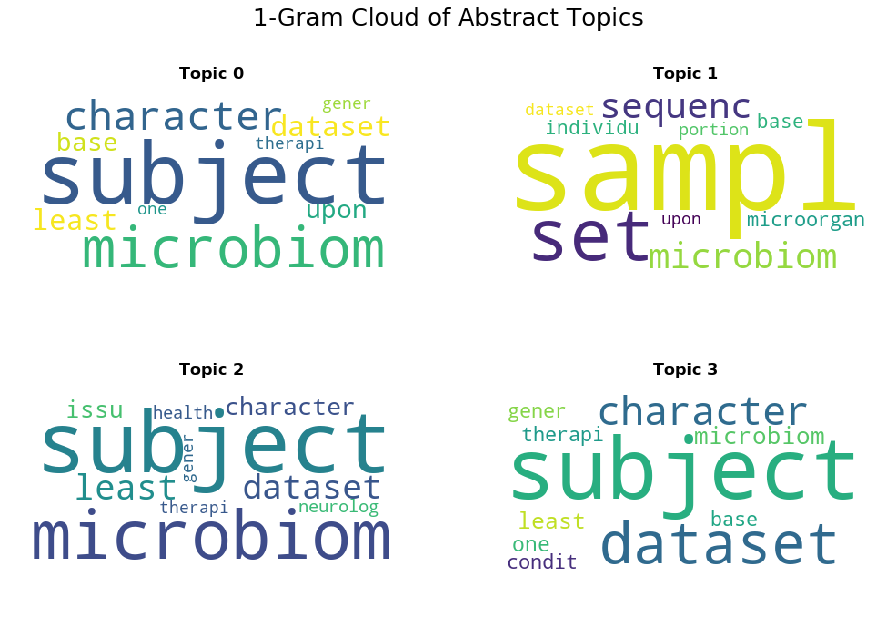

In [134]:
topic_word_cloud(num_topics = number_topics, lda_model = lda_models['1_model'], ngram='1')

#### Phrases from 2-Gram Topics

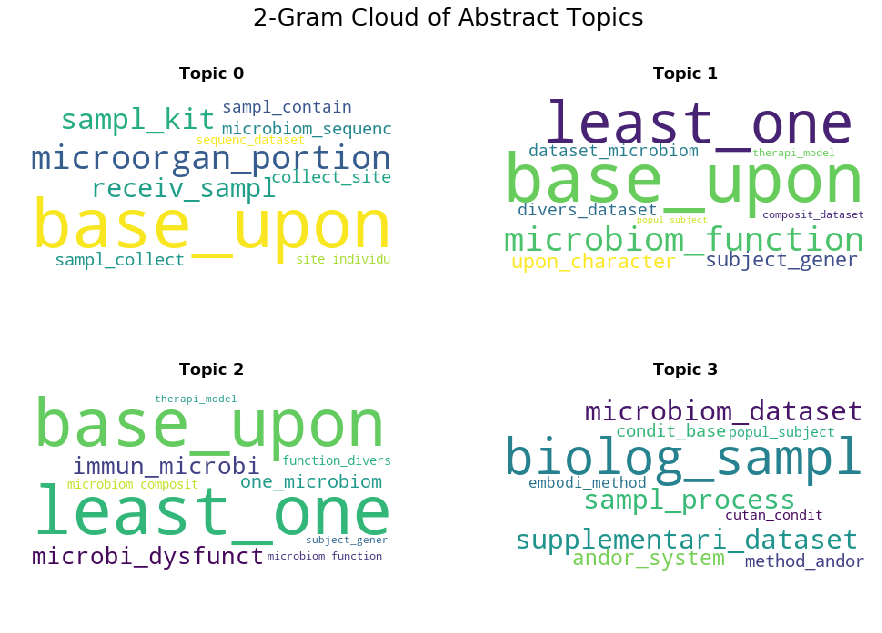

In [25]:
topic_word_cloud(num_topics = number_topics, lda_model = lda_models['2_model'], ngram='2')

#### Phrases from 3-Gram Topics

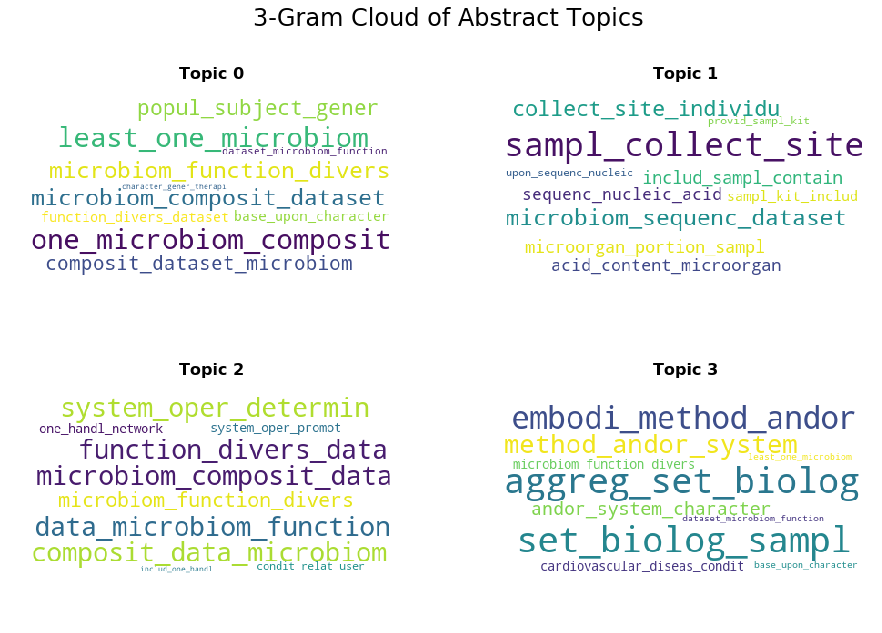

In [26]:
topic_word_cloud(num_topics = number_topics, lda_model = lda_models['3_model'], ngram='3')

#### pyLDAvis Visualization

In [27]:
pyLDAvis.enable_notebook()

In [28]:
vis_3 = pyLDAvis.gensim.prepare(lda_models['3_model'], 
                              lda_models['3_corpus'], 
                              dictionary=lda_models['3_model'].id2word,)
vis_3

c:\python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.257532  0.114915       1        1  75.458412
1      0.287578  0.131268       2        1  10.594789
3     -0.102091 -0.055016       3        1  10.411932
2      0.072044 -0.191167       4        1   3.534861, topic_info=    Category        Freq                           Term       Total  loglift  \
149  Default  159.000000      microbiom_function_divers  159.000000  30.0000   
143  Default  158.000000            least_one_microbiom  158.000000  29.0000   
156  Default  158.000000         one_microbiom_composit  158.000000  28.0000   
39   Default   16.000000             sampl_collect_site   16.000000  27.0000   
25   Default   16.000000      microbiom_sequenc_dataset   16.000000  26.0000   
406  Default   15.000000          collect_site_individu   15.000000  25.0000   
59   Default   83.000000              aggreg_set_biolog   83.000000  24.0000   
162  Default   83.000000               set_biolog_sampl   83.000000  23.0000   
9    Default   73.000000              dataset_base_upon   73.000000  22.0000   
70   Default   25.000000   cardiovascular_diseas_condit   25.000000  21.0000   
28   Default    9.000000       microorgan_portion_sampl    9.000000  20.0000   
20   Default    9.000000           includ_sampl_contain    9.000000  19.0000   
34   Default    9.000000               provid_sampl_kit    9.000000  18.0000   
46   Default    9.000000           sequenc_nucleic_acid    9.000000  17.0000   
17   Default    9.000000        gener_microbiom_sequenc    9.000000  16.0000   
29   Default    9.000000           nucleic_acid_content    9.000000  15.0000   
45   Default    9.000000           sequenc_dataset_base    9.000000  14.0000   
7    Default    9.000000     content_microorgan_portion    9.000000  13.0000   
4    Default    9.000000              base_upon_sequenc    9.000000  12.0000   
0    Default    9.000000        acid_content_microorgan    9.000000  11.0000   
22   Default    9.000000               kit_includ_sampl    9.000000  10.0000   
58   Default    9.000000           upon_sequenc_nucleic    9.000000   9.0000   
42   Default    9.000000               sampl_kit_includ    9.000000   8.0000   
86   Default   23.000000           condit_least_subject   23.000000   7.0000   
206  Default    8.000000            method_andor_system    8.000000   6.0000   
203  Default    8.000000            embodi_method_andor    8.000000   5.0000   
105  Default  155.000000     dataset_microbiom_function  155.000000   4.0000   
67   Default  155.000000            base_upon_character  155.000000   3.0000   
273  Default    8.000000                condit_set_user    8.000000   2.0000   
381  Default    8.000000                user_includ_one    8.000000   1.0000   
..       ...         ...                            ...         ...      ...   
446   Topic4    3.976284           function_divers_data    4.686399   3.1782   
536   Topic4    3.975805           system_oper_determin    4.688133   3.1777   
477   Topic4    3.970403        microbiom_composit_data    4.690514   3.1758   
410   Topic4    3.969271        composit_data_microbiom    4.691684   3.1753   
537   Topic4    2.068230             system_oper_promot    2.748230   3.0582   
415   Topic4    2.067746              condit_relat_user    2.748367   3.0579   
490   Topic4    2.067982              one_handl_network    2.748719   3.0579   
455   Topic4    2.067255               includ_one_handl    2.748806   3.0576   
476   Topic4    2.067072     microbiom_character_system    2.748970   3.0574   
546   Topic4    2.067228           user_character_model    2.749340   3.0573   
392   Topic4    2.066951        base_microorgan_sequenc    2.749107   3.0573   
531   Topic4    2.066823      supplementari_data_associ    2.749250   3.0572   
438   Topic4    2.066706               divers_data_base    2.749207   3.0571   
468   Topic4    2.066611     mate

## Claims Data

The next interesting piece of text associated with patents are their claims. 

I'll combine and clean the claims. I'll also remove some common words that don't add anything to the plots below. 

There's going to be less commentary through this section as its very similar to the abstracts.

In [41]:
claims = [' '.join(i['claims']).lower() for i in ubiome_patents.values() if i['claims'] is not None]
claims = [re.sub('[,;#()-:_]|(\.)|(\.$)', '', i) for i in claims]
claims = [re.sub(' +', ' ', i) for i in claims]
claims = [re.sub('(method)|(claim)', '', i) for i in claims]
claims[:5]

<>:2: DeprecationWarning: invalid escape sequence \.
<>:2: DeprecationWarning: invalid escape sequence \.
<>:2: DeprecationWarning: invalid escape sequence \.
<ipython-input-41-ed5dc1348454>:2: DeprecationWarning: invalid escape sequence \.
  claims = [re.sub('[,;#()-:_]|(\.)|(\.$)', '', i) for i in claims]


['s we  a  for characterizing human papillomavirus contemporaneously with generating analysis of a microbiome of an individual comprising from a sample handling network providinga sampling kit to the individual at a location remote from the sample handling network the sampling kit including a sample container configured to receive a sample from a collection site of the individual at the sample handling network receiving thesample container with the sample collected from the collection site of the individual at a sample processing module within the sample handling network generating a microbiome composition dataset based upon sequencing nucleic acid content of amicroorganism portion of the sample detecting a presence of a set of microbiome targets at the microbiome composition dataset the set of microbiome targets associated with both a plurality of human papillomavirus types and the microbiome ofthe individual generating a microbiome functional diversity dataset based on the detected s

### N-Gram Lists

In [43]:
fil_claims = []
c_ngrams_2 = []
c_ngrams_3 = []

c_corpus_1grams = []
c_corpus_2grams = []
c_corpus_3grams = []
### Loop through abstracts and build 1-gram, 2-gram and 3-gram lists
for claim in tqdm(claims, total=len(claims)):
    word_tokens = word_tokenize(claim)
    ### Stem each word and remove stop words
    filtered_claim = [st.stem(w) for w in word_tokens if not w in stop_words]
    
    ### Append each list of filtered words from each abstract to a `fil_abstracts` for later
    fil_claims.append(filtered_claim)
    
    ### Create n-gram objects using TextBlob 
    ngram_2 = TextBlob(' '.join(filtered_claim)).ngrams(2)
    ngram_3 = TextBlob(' '.join(filtered_claim)).ngrams(3)
    ### Join each n-gram with an underscore then add them to the ngram corpuses
    c_ngrams_2.append(['_'.join(i) for i in ngram_2])
    c_ngrams_3.append(['_'.join(i) for i in ngram_3])
    
    ### Add the list of words to the 1-gram corpus list
    c_corpus_1grams += filtered_claim
    c_corpus_2grams += ['_'.join(i) for i in ngram_2]
    c_corpus_3grams += ['_'.join(i) for i in ngram_3]

### Take the set of each corpus because we don't need repeats
c_corpus_1grams = list(set(c_corpus_1grams))
c_corpus_2grams = list(set(c_corpus_2grams))
c_corpus_3grams = list(set(c_corpus_3grams))

### N-Gram Frequencies

In [44]:
### Term Frequency across all abstracts
c_freq_dicts = {}
c_df_dicts = {}

for ngram, list_of_grams in [('1', fil_claims), ('2', c_ngrams_2), ('3', c_ngrams_3)]:
    freq_dict = {}
    for claim_words in list_of_grams:
        for word in claim_words:
            if word not in freq_dict.keys():
                freq_dict[word] = 1
            else:
                freq_dict[word] += 1
    c_freq_dicts[ngram] = freq_dict

    ### Document Frequency counting number of abstracts a word appears in
    df_dict = {}
    for claim_words in list_of_grams:
        for word in set(claim_words):
            if word not in df_dict.keys():
                df_dict[word] = 1
            else:
                df_dict[word] += 1
    c_df_dicts[ngram] = df_dict
    

### N-Gram Plots
#### 1-Gram

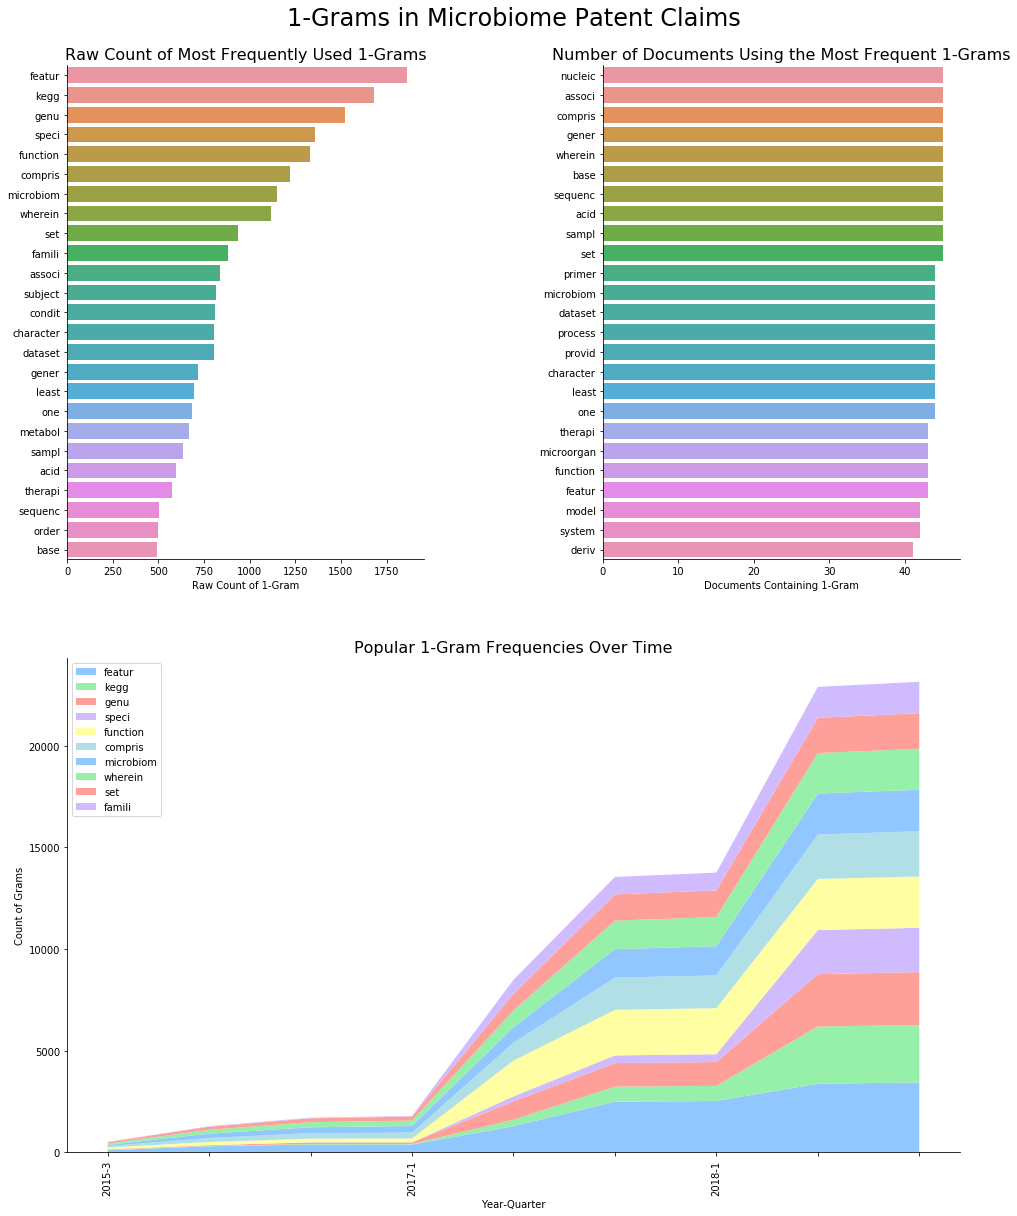

In [135]:
n_gram_analysis(freq_dicts = c_freq_dicts, df_dicts = c_df_dicts, 
                list_of_ngrams = fil_claims, ngram = '1', plot_title=f'1-Grams in Microbiome Patent Claims')

#### 2-Gram

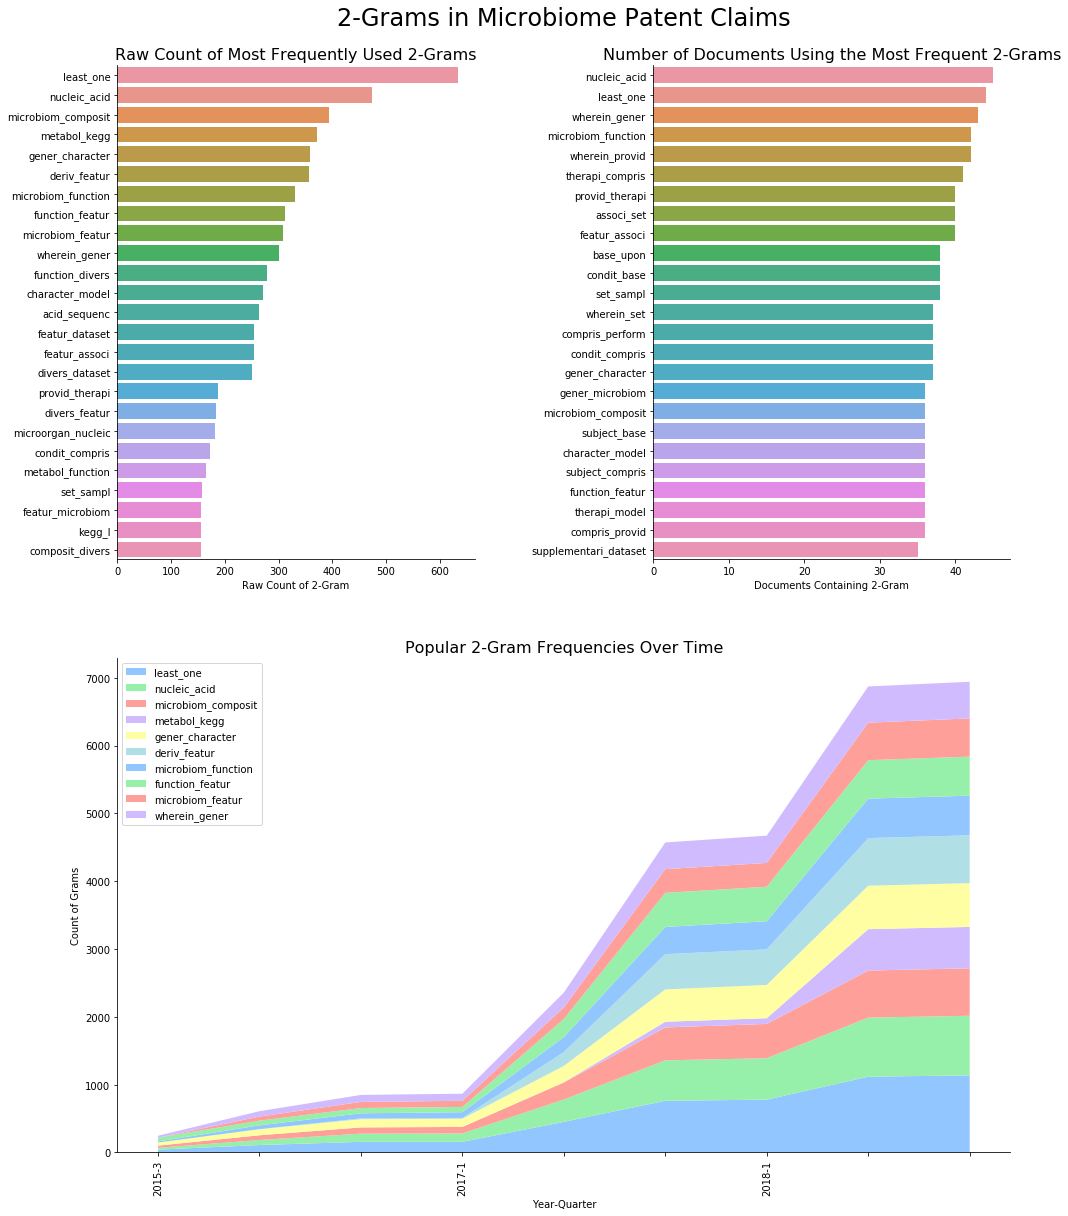

In [136]:
n_gram_analysis(freq_dicts = c_freq_dicts, df_dicts = c_df_dicts, 
                list_of_ngrams = c_ngrams_2, ngram = '2', plot_title=f'2-Grams in Microbiome Patent Claims')

#### 3-Gram

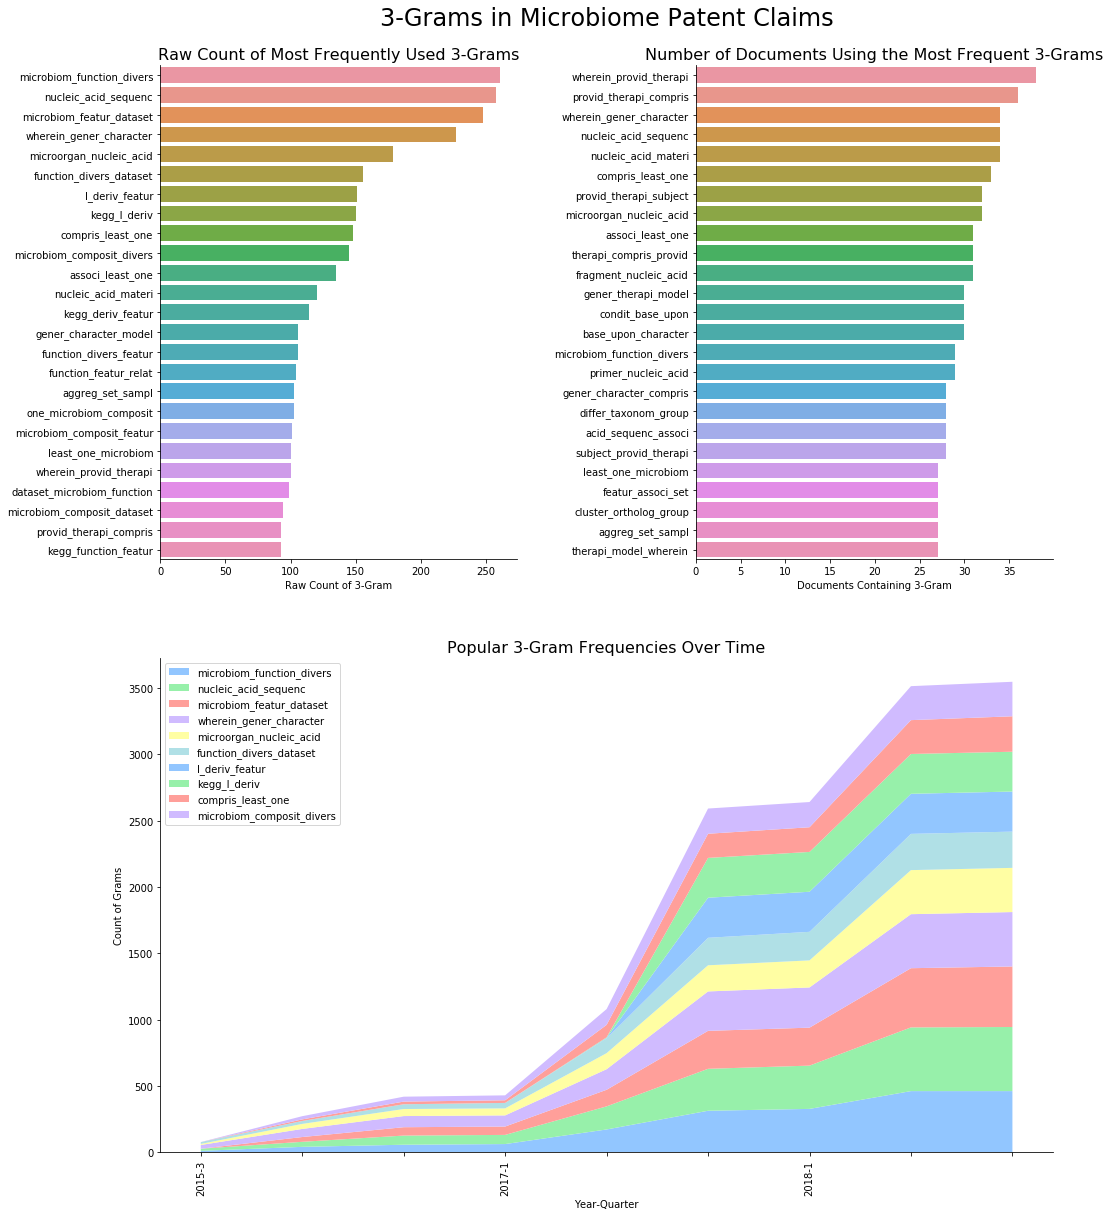

In [137]:
n_gram_analysis(freq_dicts = c_freq_dicts, df_dicts = c_df_dicts, 
                list_of_ngrams = c_ngrams_3, ngram = '3', plot_title=f'3-Grams in Microbiome Patent Claims')

### LDA Topic Modeling

In [48]:
c_lda_models = {}
c_number_topics = 4

for ngram, list_of_grams in tqdm([('1', fil_claims), ('2', c_ngrams_2), ('3', c_ngrams_3)], total=3):
    print(f'Creating {ngram}-Gram LDA Topic Model with {number_topics} Topics')
    
    count_vectorizer = CountVectorizer(stop_words='english')
    
    count_data = count_vectorizer.fit_transform([' '.join(i) for i in list_of_grams])

    lda = LDA(n_components=number_topics, n_jobs=-1)
    lda.fit(count_data)
    ### Create a dictionary of ID to word mappings
    id2word = corpora.Dictionary(list_of_grams)
    
    corpus = [id2word.doc2bow(text) for text in list_of_grams]
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=number_topics, 
                                               update_every=1,
                                               passes=10,
                                               alpha='symmetric',
                                               iterations=100,
                                               per_word_topics=True)

    for topic in lda_model.print_topics():
        print('\t', topic)
    c_lda_models[f'{ngram}_model'] = lda_model
    c_lda_models[f'{ngram}_corpus'] = corpus
    

Creating 1-Gram LDA Topic Model with 4 Topics
	 (0, '0.112*"function" + 0.053*"genu" + 0.046*"famili" + 0.033*"order" + 0.032*"metabol" + 0.024*"class" + 0.016*"speci" + 0.014*"phylum" + 0.011*"biosynthesi" + 0.008*"featur"')
	 (1, '0.053*"featur" + 0.033*"compris" + 0.029*"microbiom" + 0.028*"wherein" + 0.025*"set" + 0.024*"subject" + 0.023*"character" + 0.022*"function" + 0.022*"dataset" + 0.022*"associ"')
	 (2, '0.031*"set" + 0.029*"sampl" + 0.029*"sequenc" + 0.025*"wherein" + 0.024*"compris" + 0.021*"microbiom" + 0.019*"microorgan" + 0.019*"individu" + 0.014*"gener" + 0.012*"user"')
	 (3, '0.081*"kegg" + 0.071*"speci" + 0.051*"genu" + 0.025*"sp" + 0.024*"famili" + 0.023*"metabol" + 0.013*"order" + 0.012*"featur" + 0.010*"bacteroid" + 0.009*"biosynthesi"')
Creating 2-Gram LDA Topic Model with 4 Topics
	 (0, '0.012*"metabol_function" + 0.009*"least_one" + 0.007*"nucleic_acid" + 0.005*"microbiom_featur" + 0.004*"function_featur" + 0.004*"wherein_gener" + 0.004*"featur_dataset" + 0.004

#### Phrases from 1-Gram Claims Topics

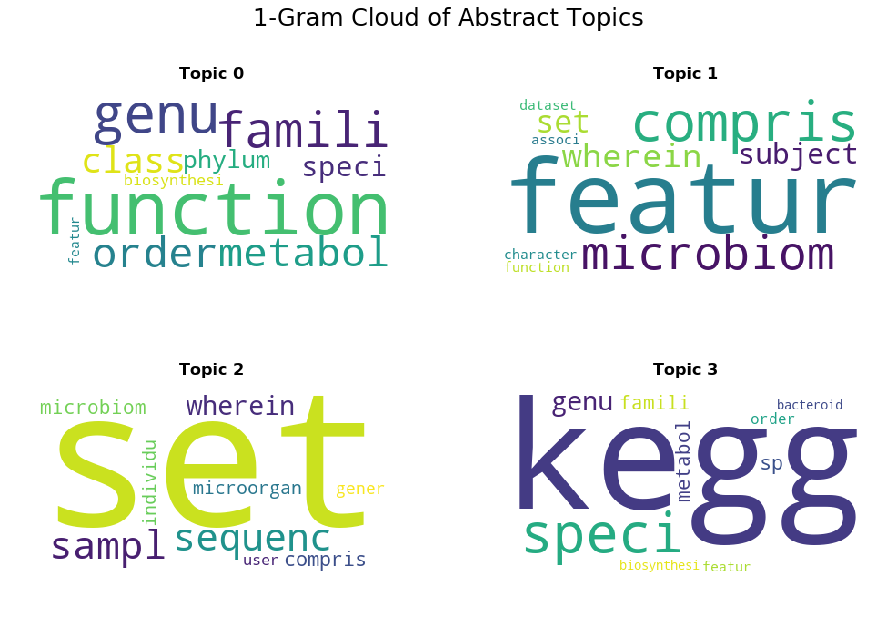

In [49]:
topic_word_cloud(num_topics = c_number_topics, lda_model = c_lda_models['1_model'], ngram='1')

#### Phrases from 2-Gram Claims Topics

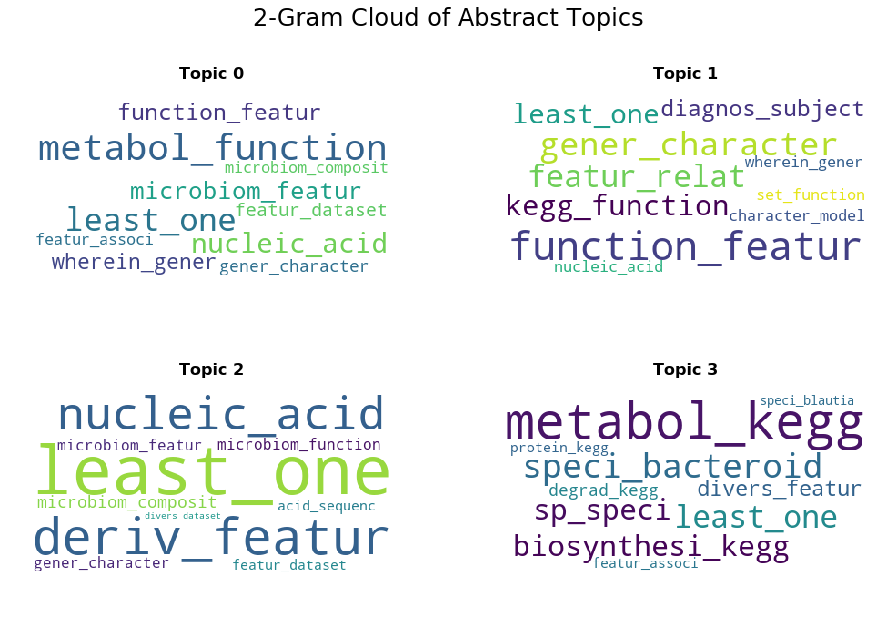

In [50]:
topic_word_cloud(num_topics = c_number_topics, lda_model = c_lda_models['2_model'], ngram='2')

#### Phrases from 3-Gram Claims Topics

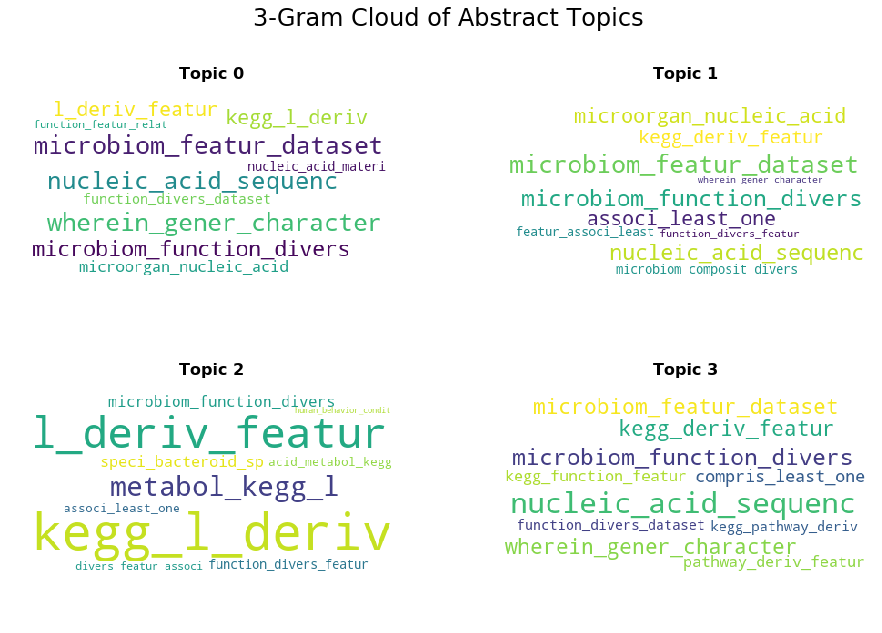

In [51]:
topic_word_cloud(num_topics = c_number_topics, lda_model = c_lda_models['3_model'], ngram='3')

#### pyLDAvis Visualization

In [52]:
vis_3 = pyLDAvis.gensim.prepare(c_lda_models['3_model'], 
                              c_lda_models['3_corpus'], 
                              dictionary=c_lda_models['3_model'].id2word,)
vis_3

c:\python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.097889 -0.038990       1        1  32.718914
0     -0.135997  0.098731       2        1  32.469898
3     -0.123099 -0.094526       3        1  24.378569
2      0.161206  0.034786       4        1  10.432620, topic_info=      Category        Freq                          Term       Total  loglift  \
14268  Default  234.000000                l_deriv_featur  234.000000  30.0000   
14247  Default  233.000000                  kegg_l_deriv  233.000000  29.0000   
8170   Default   88.000000          pathway_deriv_featur   88.000000  28.0000   
6698   Default   87.000000            kegg_pathway_deriv   87.000000  27.0000   
909    Default  168.000000         function_featur_relat  168.000000  26.0000   
18301  Default   62.000000                metabol_kegg_l   62.000000  25.0000   
1731   Default  351.000000       wherein_gener_character  351.000000  24.0000   
14242  Default  157.000000          kegg_function_featur  157.000000  23.0000   
1209   Default  411.000000          nucleic_acid_sequenc  411.000000  22.0000   
9688   Default   63.000000            speci_bacteroid_sp   63.000000  21.0000   
1123   Default  390.000000      microbiom_featur_dataset  390.000000  20.0000   
925    Default   79.000000      gener_character_diagnost   79.000000  19.0000   
14753  Default   38.000000          neurolog_health_issu   38.000000  18.0000   
338    Default  158.000000              aggreg_set_sampl  158.000000  17.0000   
18952  Default   45.000000            sjogren_'s_syndrom   45.000000  16.0000   
2316   Default   49.000000             acid_metabol_kegg   49.000000  15.0000   
1842   Default  131.000000       composit_divers_dataset  131.000000  14.0000   
6286   Default   32.000000         human_behavior_condit   32.000000  13.0000   
782    Default   84.000000          divers_featur_associ   84.000000  12.0000   
16700  Default   40.000000             's_syndrom_condit   40.000000  11.0000   
6583   Default  189.000000             kegg_deriv_featur  189.000000  10.0000   
15879  Default   32.000000     set_gastrointestin_condit   32.000000   9.0000   
91     Default  232.000000       function_divers_dataset  232.000000   8.0000   
558    Default   60.000000       compris_diagnos_subject   60.000000   7.0000   
17403  Default   38.000000         deficit_disord_condit   38.000000   6.0000   
19890  Default   38.000000  cardiovascular_diseas_condit   38.000000   5.0000   
14038  Default   30.000000        immun_microbi_dysfunct   30.000000   4.0000   
11601  Default   42.000000         attent_deficit_disord   42.000000   3.0000   
562    Default  120.000000       compris_gener_character  120.000000   2.0000   
749    Default   67.000000       determin_presenc_featur   67.000000   1.0000   
...        ...         ...                           ...         ...      ...   
2909    Topic4    4.750105      backbon_biosynthesi_kegg   12.239954   1.3137   
6723    Topic4    4.748593   kegg_plantpathogen_interact   12.240673   1.3133   
10378   Topic4    4.751174            sugar_metabol_kegg   12.249738   1.3131   
12548   Topic4    5.440762                 degrad_kegg_l   14.670332   1.2683   
2316    Topic4   13.985153             acid_metabol_kegg   49.727581   0.9917   
6510    Topic4    9.359059               kegg_amino_acid   29.655933   1.1069   
3486    Topic4    8.702733        carbohydr_metabol_kegg   27.300323   1.1170   
9649    Topic4    8.049026              speci_alistip_sp   24.947083   1.1290   
6472    Topic4    8.039680              ion_channel_kegg   24.935955   1.1283   
6762    Topic4    8.033184        kegg_ribosom_biogenesi   24.927172   1.1279   
9169    Topic4    8.034751      secondari_metabolit_kegg   24.936848   1.1277   
9730    Topic4    8.043312              speci_blautia_sp   25.789076   1.0951   
6550    Topic4    7.384261        kegg_carbohydr_metabol   23.412262 